# Binary Classification of Pneumonia and Normal 
This project focuses on binary classification of chest X-ray images into **Pneumonia** and **Normal** categories using a VGGNet16 architecture with **Transfer Learning**. The goal is to maximize model performance through careful training strategies, including K-Fold cross-validation, soft voting ensembles, and post-training threshold tuning.

While we achieved strong results, key limitations include limited labeled data, class imbalance, and variations across datasets. To evaluate generalization, we tested the model on an external dataset as well. This setup helps simulate real-world performance and avoid overfitting to a single source.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import os
import random
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data Exploration & Preparation
Before training the model, we’ll perform a thorough analysis of the dataset to ensure it's suitable for our task. This includes:

- Checking image sizes to verify consistency and detect any unusually small or large images
- Analyzing class distributions to see how many images belong to each category (Normal vs Pneumonia)
- Evaluating class balance to determine if the dataset is imbalanced and whether augmentation or sampling strategies are needed

These steps will help us identify any issues early and prepare the data effectively for training.

#### Checking the image sizes of each dataset

In [2]:
main_folder = "/kaggle/input/chest-xray-pneumonia/chest_xray"
image_size = {}
size = []

# getting the train/test/val set
for dataset in ['train', 'val', 'test']:  
    set_path = os.path.join(main_folder, dataset)

     # getting the class
    for label in ['NORMAL', 'PNEUMONIA']: 
        img_folder = os.path.join(set_path, label)

        # getting the images
        for filename in os.listdir(img_folder):
            img_path = os.path.join(img_folder, filename)
            with Image.open(img_path) as img:
                size.append(img.size)

        image_size[dataset + '/' + label] = {
            'min': min(size, key=lambda x: x[0]*x[1]),
            'max': max(size, key=lambda x: x[0]*x[1])}

for k,v in image_size.items():
    print(f"{k} : {v}")

train/NORMAL : {'min': (912, 672), 'max': (2916, 2583)}
train/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}
val/NORMAL : {'min': (384, 127), 'max': (2916, 2583)}
val/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}
test/NORMAL : {'min': (384, 127), 'max': (2916, 2583)}
test/PNEUMONIA : {'min': (384, 127), 'max': (2916, 2583)}


#### Setting Image Transformations for VGG16
We chose our resizing strategy after analyzing the minimum and maximum image sizes in the dataset. This helps ensure that all images — whether very small or very large — are transformed in a way that’s safe, consistent, and compatible with VGG16’s input requirements.

In [3]:
transform_VGG16 = transforms.Compose([
    # converting our grayscale x-rays to RGB
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(         
        mean=[0.485, 0.456, 0.406],    
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
train_dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [5]:
train_dataset = datasets.ImageFolder(train_dataset_path, transform = transform_VGG16)
train_dataset.classes

['NORMAL', 'PNEUMONIA']

In [7]:
val_dataset = datasets.ImageFolder(val_dataset_path, transform = transform_VGG16)

In [8]:
train_dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

Checking the size of each class and examining any one random image from each 

In [9]:
Counter(train_dataset.targets)

Counter({0: 1341, 1: 3875})

#### The Train Set is Not Balanced
We'll be using Augmentor to perform augmentation and balancing at the same time.

#### Augmentation Strategy
Instead of only augmenting the minority NORMAL class, I chose to apply light augmentation to NORMAL and stronger augmentation to PNEUMONIA.
This helps balance the dataset and improves generalization, especially for pneumonia cases that may appear in varied forms.

In medical tasks like this, false negatives are more dangerous than false positives. So by making the PNEUMONIA class more diverse with controlled augmentations, the model can better learn to detect it in real-world situations.

#### Safe Augmentations Used
Since we’re working with chest X-rays, we’ll stick to safe and medically reasonable transformations:

- Brightness/Contrast (small changes)
- RandomRotation (±10°)
- Zooming in (very slight, preserves full anatomy)

reference used for augmentation: https://youtu.be/mygPhlH8un0?si=ZuaWM-hD-SMlUmZP

In [10]:
!pip install Augmentor

In [11]:
import Augmentor

In [12]:
# for our NORMAL class
output_dir = "/kaggle/working/NORMAL_augmented"
os.makedirs(output_dir, exist_ok=True)
normal_aug = Augmentor.Pipeline("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL",
                                output_directory = output_dir,
                                save_format = "jpeg")

# brightness/contrast: 90% - 110% 
# randomly applying slight brightness or contrast changes
# to make the model robust to real-world variations 
normal_aug.random_brightness(probability=0.5, min_factor=0.9, max_factor=1.1)  
normal_aug.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.1)

# adding 3534 more images to make the dataset balanced  
normal_aug.sample(3534)  

Initialised with 1341 image(s) found.
Output directory set to /kaggle/working/NORMAL_augmented.

Processing <PIL.Image.Image image mode=L size=1474x1527 at 0x7F8FCA94E950>: 100%|██████████| 3534/3534 [00:46<00:00, 75.22 Samples/s]                   


In [13]:
# for our PNEUMONIA class (adding a bit more variations)
output_dir = "/kaggle/working/PNEUMONIA_augmented"
os.makedirs(output_dir, exist_ok=True)
pneumonia_aug = Augmentor.Pipeline("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA",
                                   output_directory = output_dir,
                                   save_format = "jpeg")

# brightness/contrast: 85% - 115% 
pneumonia_aug.random_brightness(probability=0.7, min_factor=0.85, max_factor=1.15)
pneumonia_aug.random_contrast(probability=0.7, min_factor=0.85, max_factor=1.15)

# rotation is also kept minimal of about ±10°
pneumonia_aug.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

# zoom factor is also minimal to avoid losing much information
# between 10% and 20%
pneumonia_aug.zoom(probability=0.6, min_factor=1.1, max_factor=1.2)
pneumonia_aug.sample(1000)  # adding 1000 more images


Initialised with 3875 image(s) found.
Output directory set to /kaggle/working/PNEUMONIA_augmented.

Processing <PIL.Image.Image image mode=L size=1256x1032 at 0x7F8FE02A10D0>: 100%|██████████| 1000/1000 [00:24<00:00, 40.79 Samples/s]                 


#### Merging the original and augmented images

In [14]:
normal_merge = "/kaggle/working/NORMAL_merged"
pneumonia_merge = "/kaggle/working/PNEUMONIA_merged"
os.makedirs(normal_merge, exist_ok = True)
os.makedirs(pneumonia_merge, exist_ok = True)

In [15]:
import shutil

for label in ['NORMAL','PNEUMONIA']:
    aug_source_dir = "/kaggle/working/" + label + "_augmented"
    orig_source_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/" + label
    dest_dir = "/kaggle/working/" + label + "_merged"

    # moving the augmented images
    for new_img in os.listdir(aug_source_dir):
        src = os.path.join(aug_source_dir, new_img)
        dest = os.path.join(dest_dir, new_img)
        shutil.move(src, dest)

    # copying the original images
    for img in os.listdir(orig_source_dir):
        src = os.path.join(orig_source_dir, img)
        dest = os.path.join(dest_dir, img)
         # to avoid permission errors of kaggle/input we're using copy
        shutil.copy(src, dest)  

print("images moved successfully!")

images moved successfully!


In [16]:
shutil.rmtree("/kaggle/working/NORMAL_augmented")
shutil.rmtree("/kaggle/working/PNEUMONIA_augmented")

In [17]:
output_dir = "/kaggle/working/trainSet"
os.makedirs(output_dir, exist_ok = True)

shutil.move(normal_merge, output_dir)
shutil.move(pneumonia_merge, output_dir)

'/kaggle/working/trainSet/PNEUMONIA_merged'

In [18]:
new_train_path = "/kaggle/working/trainSet"
new_train_dataset = datasets.ImageFolder(new_train_path, transform=transform_VGG16)
Counter(new_train_dataset.targets)

Counter({0: 4875, 1: 4875})

#### Now our training set is balanced!

## Using Another Dataset as Tester

The original test set provided with our main dataset was too small to provide a meaningful evaluation of our model's performance. To overcome this limitation, we used a **separate chest X-ray dataset** as our external test set.

This allowed us to evaluate how well our model generalizes to unseen data from a different source, helping verify its real-world applicability. The new test set included both Normal and Pneumonia cases, giving us a more reliable and diverse benchmark for final performance metrics.

In [31]:
output_dir = "/kaggle/working/testSet"
os.makedirs(output_dir, exist_ok = True)

shutil.copytree("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal", os.path.join(output_dir, "Normal"))
shutil.copytree("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia",  os.path.join(output_dir, "Pneumonia"))

shutil.rmtree("/kaggle/working/testSet/Normal/masks")
shutil.rmtree("/kaggle/working/testSet/Pneumonia/masks")

In [32]:
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_VGG16)
Counter(test_dataset.targets)

Counter({0: 10192, 1: 1345})

We're undersampling the Normal class because it has way more images (10,192) compared to the Viral Pneumonia class (1,345). Since we’re only using this data for testing, we want the model to be evaluated fairly on both classes.

If we kept the Normal class much larger, the model might get biased and perform well just by predicting “Normal” most of the time. That would give a misleading accuracy.

So, by reducing the Normal samples to match the Viral class, we create a balanced test set — this helps us measure how well the model performs on each class equally.

In [38]:
normal_dir = '/kaggle/working/testSet/Normal/images'
viral_dir = '/kaggle/working/testSet/Pneumonia/images'

# target number = match minority class
target = len(os.listdir(viral_dir))

# get list of normal images
normal_images = os.listdir(normal_dir)
random.shuffle(normal_images)

# keep only the first `target` images
keep = set(normal_images[:target])

for img in normal_images:
    if img not in keep:
        os.remove(os.path.join(normal_dir, img))

In [39]:
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_VGG16)
Counter(test_dataset.targets)

Counter({0: 1345, 1: 1345})

In [40]:
testing_loader = DataLoader(test_dataset, batch_size = 32)

Now our Testing set is prepared!

## Preparing our Validation Set

To ensure a reliable evaluation after training, we created a separate validation set ahead of time. This was done by combining 200 images per class from the test set with the original validation set, resulting in a balanced set of approximately **400 Normal** and **400 Pneumonia** images.

This validation set was **not used during training** — instead, K-Fold cross-validation was applied on the training set to train the models. The prepared validation set was reserved for **post-training fine-tuning**, such as **threshold selection** and **soft-voting ensemble evaluation**.

In [55]:
# checking our validation set
Counter(val_dataset.targets)

Counter({0: 208, 1: 208})

In [57]:
import os, random, shutil

output_dir = "/kaggle/working/valSet"
os.makedirs(output_dir, exist_ok=True)

for label in ['Normal', 'Pneumonia']:
    new_source_dir = "/kaggle/working/testSet/" + label + "/images"
    orig_source_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/" + label.upper()
    dest_dir = "/kaggle/working/valSet/" + label
    os.makedirs(dest_dir, exist_ok=True)

    # moving approx 200 images from testSet to valSet
    images = os.listdir(new_source_dir)
    random.shuffle(images)
    keep = set(images[:200])

    for img in images:
        if img in keep:
            src = os.path.join(new_source_dir, img)
            dest = os.path.join(dest_dir, f"test_{img}")
            shutil.move(src, dest)

    # copy Kaggle original val images into valSet
    for img in os.listdir(orig_source_dir):
        src = os.path.join(orig_source_dir, img)
        dest = os.path.join(dest_dir, f"val_{img}")
        shutil.copy(src, dest)

print("Images moved successfully!")

Images moved successfully!


In [58]:
val_path = "/kaggle/working/valSet"
val_dataset = datasets.ImageFolder(val_path, transform=transform_VGG16)
Counter(val_dataset.targets)

Counter({0: 416, 1: 416})

In [59]:
final_val_loader = DataLoader(val_dataset, batch_size = 32)

In [68]:
# refreshing the test set
test_path = "/kaggle/working/testSet"
test_dataset = datasets.ImageFolder(test_path, transform=transform_VGG16)
Counter(test_dataset.targets)

Counter({0: 945, 1: 945})

In [69]:
testing_loader = DataLoader(test_dataset, batch_size = 32)

## Shift to K-Fold Cross Validation
As mentioned we had switched to 3-Fold Cross Validation using only the train_dataset.
This helped us:
- Avoid overfitting to one small validation set
- Train on a wider variety of samples
- Pick the 3 best-performing models across different folds

## Focus on Recall
During training, the main focus was on maximizing recall, because missing even a single pneumonia case was considered riskier than false positives.
So even if precision dropped slightly during training, high recall was prioritized to catch as many pneumonia cases as possible.

This method is performed below: 

## Transfer Learning on VGGNet16

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [61]:
def create_model():
    vgg16 = models.vgg16(pretrained = True)
    
    # freezing all weights
    for params in vgg16.parameters():
        params.requires_grad = False
    
    # unfreezing the last convulution block
    for layer in list(vgg16.features.children())[24:]:
        for param in layer.parameters():
            param.requires_grad = True
    
    # adjusting the last layer to our classification
    vgg16.classifier[6] = nn.Linear(4096, 1)

    vgg16.to(device)

    # setting
    loss_func = nn.BCEWithLogitsLoss()  # has sigmoid 
    # optimizer = optim.Adam(filter(lambda p:p.requires_grad == True, vgg16.parameters()), lr=0.001)
    
    block5_params = []
    
    # block 5 
    for layer in list(vgg16.features.children())[24:]:
        block5_params += list(layer.parameters())                          
    
    optimizer = optim.Adam([
        {'params': vgg16.classifier.parameters(), 'lr': 1e-4},   # classifier
        {'params': block5_params, 'lr': 1e-6}
    ], weight_decay=1e-4)

    return vgg16, optimizer, loss_func

In [62]:
def Train_model(model, e, fold_no, train_loader, val_loader, optimizer, loss_func):
    counter = 0
    patience = 7
    best_recall = 0

    for epoch in range(e):
        model.train()
        total_loss = 0
        train_total = 0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.round(torch.sigmoid(outputs))
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        train_accuracy = train_correct / train_total * 100

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_total_loss = 0
        pred_classes = []
        actual_classes = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
                outputs = model(images)
                loss = loss_func(outputs, labels)
                val_total_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))

                pred_classes.extend(predicted.cpu().numpy())
                actual_classes.extend(labels.cpu().numpy())

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total * 100
        precision = precision_score(actual_classes, pred_classes)
        recall = recall_score(actual_classes, pred_classes)
        f1 = f1_score(actual_classes, pred_classes)

        print(f"Epoch: {epoch+1}, Train Loss: {total_loss:.2f}, "
              f"Train Acc: {train_accuracy:.2f}%, Val Loss: {val_total_loss:.2f}, "
              f"Val Acc: {val_accuracy:.2f}%")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

        if recall > best_recall:
            best_recall = recall
            all_recalls.append(best_recall)
            counter = 0
            torch.save(model.state_dict(), f"best_model_{fold_no}.pth")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break


### Training Code 

In [ ]:
# all_recalls = []
# n = 3
# kfolds = KFold(n_splits = n, shuffle = True, random_state = 42)

# for fold, (train_idx, val_idx) in enumerate(kfolds.split(new_train_dataset)):
#     print(f"\n--- Fold {fold+1} ---")
    
#     # Create subset samplers
#     train_subset = Subset(new_train_dataset, train_idx)
#     val_subset = Subset(new_train_dataset, val_idx)
    
#     train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

#     # Re-initializing the model
#     vgg16, optimizer, loss_func = create_model() 
    
#     # Training the model on this fold
#     Train_model(vgg16, 10, fold+1, train_loader, val_loader, optimizer, loss_func)

### Downloading best models 

In [ ]:
# # downloading the best model
# from IPython.display import FileLink
# FileLink(r'best_model_1.pth')

In [ ]:
# # saving our stats to a file
# import pickle

# with open("/kaggle/working/training_stats_Vgg16.pkl", "wb") as f:
#     pickle.dump({
#         'all_recalls': all_recalls
#     }, f)

In [ ]:
# # Loading the lists
# with open("training_stats_Vgg16.pkl", "rb") as f:
#     stats = pickle.load(f)

# # Assigning back to our original lists
# all_recalls = stats['all_recalls']

## Loading all the Three best models

In [63]:
best_model_1,_,_ = create_model()
best_model_1.load_state_dict(torch.load('/kaggle/input/vgg16-best-model-states/best_model_1.pth'))
best_model_1.to(device)

best_model_2,_,_ = create_model()
best_model_2.load_state_dict(torch.load('/kaggle/input/vgg16-best-model-states/best_model_2.pth'))
best_model_2.to(device)

best_model_3,_,_ = create_model()
best_model_3.load_state_dict(torch.load('/kaggle/input/vgg16-best-model-states/best_model_3.pth'))
best_model_3.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Fine-tuning our Threshold Value for Soft Voting
Once the 3 best models were selected:
- Their predictions were soft-voted (i.e., averaged their output probabilities)
- We'll be using our validation set to fine-tune the decision threshold

The results can be seen below:

In [64]:
def get_probabilities(model1, model2, model3, dataloader):
    model1.eval()
    model2.eval()
    model3.eval()

    pred_probs = []
    actual_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.unsqueeze(1).float().to(device)
    
            # getting predicted probabilities from all 3 models
            p1 = torch.sigmoid(model1(images))
            p2 = torch.sigmoid(model2(images))
            p3 = torch.sigmoid(model3(images))
    
            final_pred = (p1+p2+p3) / 3.0
    
            # updating our lists
            pred_probs.extend(final_pred.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    return np.array(pred_probs), np.array(actual_labels)

In [96]:
pred_prob, actual_labels = get_probabilities(best_model_1, best_model_2,
                                            best_model_3, final_val_loader)

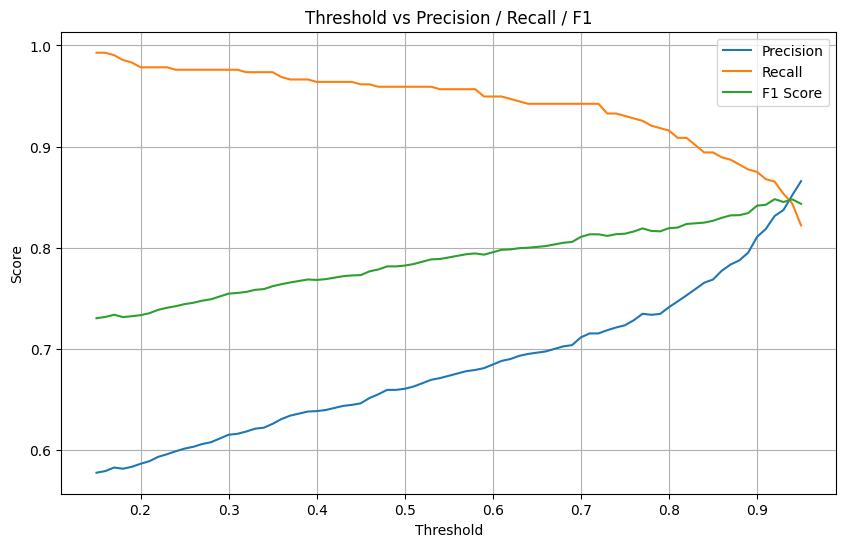

In [84]:
thresholds = np.arange(0.15, 0.96, 0.01)

precisions = []
recalls = []
f1s = []

for th in thresholds:
    preds = (pred_prob > th).astype(int)
    precisions.append(precision_score(actual_labels, preds))
    recalls.append(recall_score(actual_labels, preds))
    f1s.append(f1_score(actual_labels, preds))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision / Recall / F1')
plt.legend()
plt.grid(True)
plt.show()


In [92]:
test_pred, test_actual_labels = get_probabilities(best_model_1, best_model_2,
                                                 best_model_3, testing_loader)
Final_prediction = (test_pred > 0.79).astype(int)

acc = accuracy_score(test_actual_labels, Final_prediction)
precision = precision_score(test_actual_labels, Final_prediction)
recall = recall_score(test_actual_labels, Final_prediction)
f1 = f1_score(test_actual_labels, Final_prediction)

print(f"Accuracy: {acc*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall: {recall*100:.4f}")
print(f"F1 Score: {f1*100:.4f}")

Accuracy: 78.2011
Precision: 72.7973
Recall: 90.0529
F1 Score: 80.5109


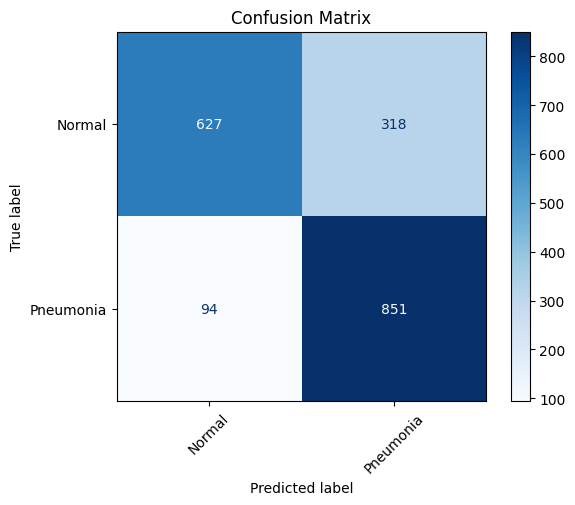

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_actual_labels, Final_prediction)
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=['Normal', 'Pneumonia'])
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")

plt.show()

## Final Test Evaluation
After experimenting with multiple threshold tuning strategies, the final ensemble model achieved the following performance on the test set:

- Accuracy: 78.20%
- Precision: 72.80%
- Recall: 90.05%
- F1 Score: 80.51%

These results indicate a strong recall for detecting pneumonia, which was the primary objective of the model. The trade-off was a slightly reduced precision, meaning more healthy patients were incorrectly flagged. However, in a medical context where missing a pneumonia case is riskier than flagging a healthy one, this is an acceptable and intentional compromise.

The final threshold was selected using a Threshold vs Precision / Recall / F1 Score plot, which helped visualize the trade-offs across a range of thresholds (0.15 to 0.95). While the F1 score technically peaked at 0.92, this came at the cost of a significant drop in recall — which was not acceptable for our use case. To maintain a high recall while still improving overall balance, we selected a threshold of 0.79, where recall remained strong and F1 score was still high. This threshold offered the most practical compromise for our final model.


In [ ]:
# # code to clear up the output folders

# import shutil
# import os

# working_dir = "/kaggle/working"

# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     try:
#         if os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#         else:
#             os.remove(item_path)
#     except Exception as e:
#         print(f"Couldn't delete {item_path}: {e}")
